# Learn VoC
### Pola Methodology

In [1]:
import pickle
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns; sns.set_context('notebook')
from datetime import datetime
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
batterySet = pickle.load(open("./Battery_Data/new_battery_cycles/new_battery_v2.p", 'rb'))

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

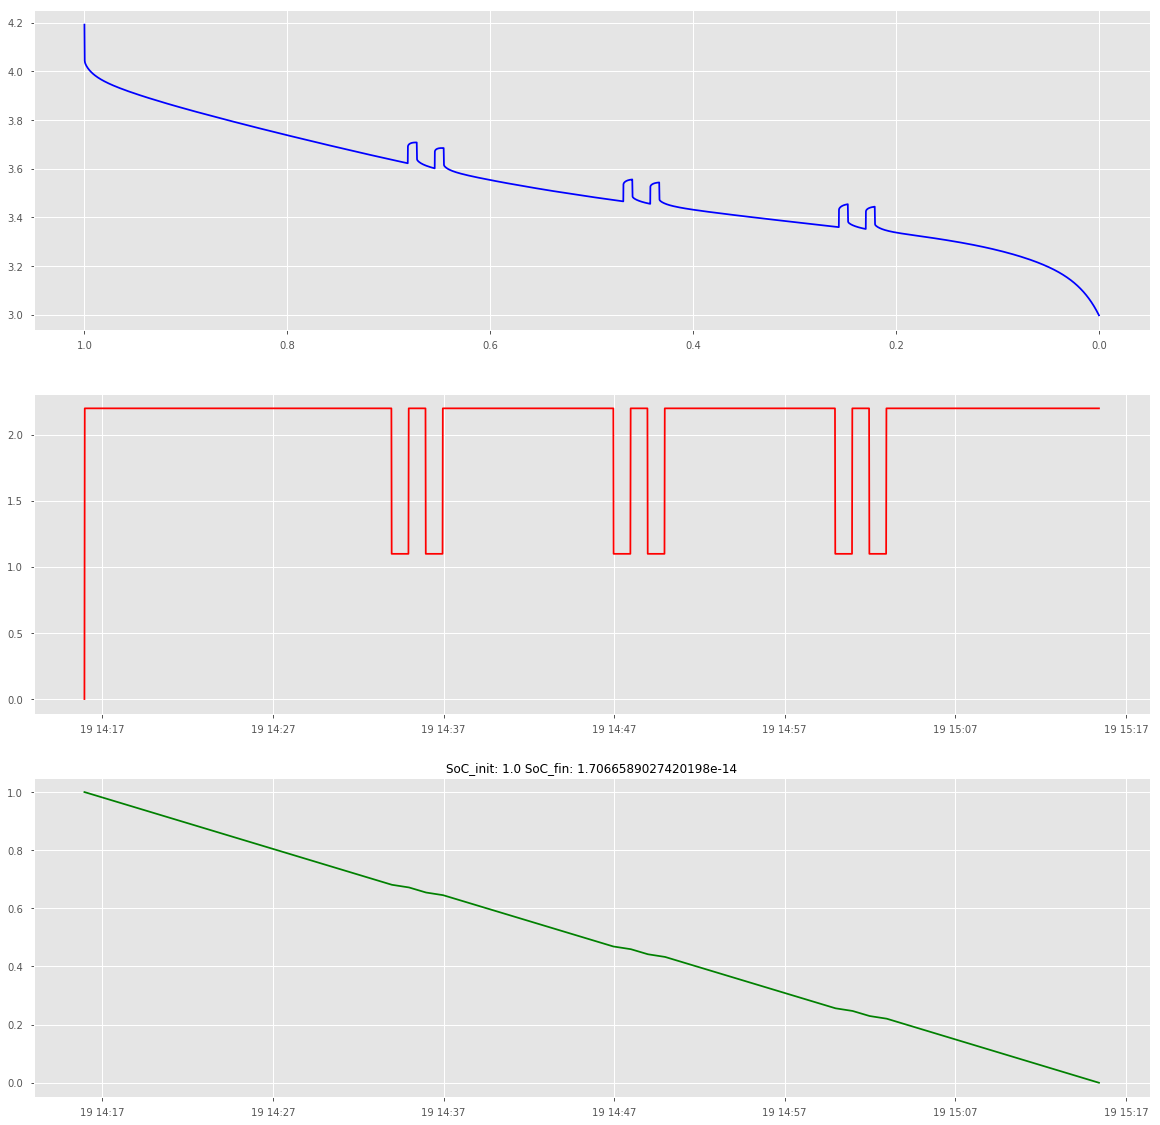

In [4]:
charSet = batterySet[1]
current = np.array(charSet['Current'], ndmin=2)*-1.0
seconds = np.ones_like(current)
C_n = np.sum(current*seconds)
SoC = []
SoC_state = 1.0
SoC_init = SoC_state
for i in range(current.shape[1]):
    SoC_state -= current[0, i]/C_n
    SoC.append(SoC_state)

Characterisation_Set = {}
Characterisation_Set['C_n'] = C_n
Characterisation_Set['SoC'] = np.array(SoC, ndmin=2)
Characterisation_Set['Current'] = current
Characterisation_Set['Voltage'] = charSet['Voltage']

matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
plt.figure("SoC Estimate")
plt.subplot(311)
plt.plot(SoC, charSet['Voltage'].T, '-b')
plt.gca().invert_xaxis()
plt.subplot(312)
plt.plot(charSet['datetime'].T, current.T, '-r')
plt.subplot(313)
plt.title("SoC_init: {0} SoC_fin: {1}".format(SoC_init, SoC[-1]))
plt.plot(charSet['datetime'].T, np.array(SoC), '-g')

## Define VoC
$|Z_p | = |\Delta V / \Delta I|$, assuming $v oc ( k ) = v ( k ) + i ( k )· Z_p$

In [5]:
high_low_index = []
low_high_index = []
for i in range(1, current.shape[1] - 1):
    if current[0, i] - current[0, i + 1] > 0.001:
        print("High -> Low", current[0, i], current[0, i+1])
        high_low_index.append(i)
    elif current[0, i + 1] - current[0, i] > 0.001:
        print("Low -> High", current[0, i], current[0, i+1])
        low_high_index.append(i)

High -> Low 2.19784 1.09795
Low -> High 1.09795 2.19784
High -> Low 2.19784 1.09795
Low -> High 1.09794 2.19783
High -> Low 2.19784 1.09795
Low -> High 1.09795 2.19784
High -> Low 2.19784 1.09795
Low -> High 1.09795 2.19784
High -> Low 2.19783 1.09795
Low -> High 1.09795 2.19784
High -> Low 2.19784 1.09795
Low -> High 1.09795 2.19784


In [6]:
delta_V = np.abs(charSet['Voltage'][0, high_low_index]-charSet['Voltage'][0, low_high_index])
delta_I = np.abs(current[0, high_low_index]-current[0, low_high_index])
delta_Z = delta_V/delta_I
Z_p = np.mean(delta_Z)
print(Z_p)
print(high_low_index)
print(low_high_index)

0.08076263685971334
[1080, 1200, 1860, 1980, 2640, 2760]
[1140, 1260, 1920, 2040, 2700, 2820]


## Zone 2



In [7]:
SoC = np.array(SoC, ndmin=2)
voltage = charSet['Voltage']

0.14816000000000074
(1, 3395) <class 'numpy.ndarray'>
(1, 3395) <class 'numpy.ndarray'>
(1, 3395) <class 'numpy.ndarray'>


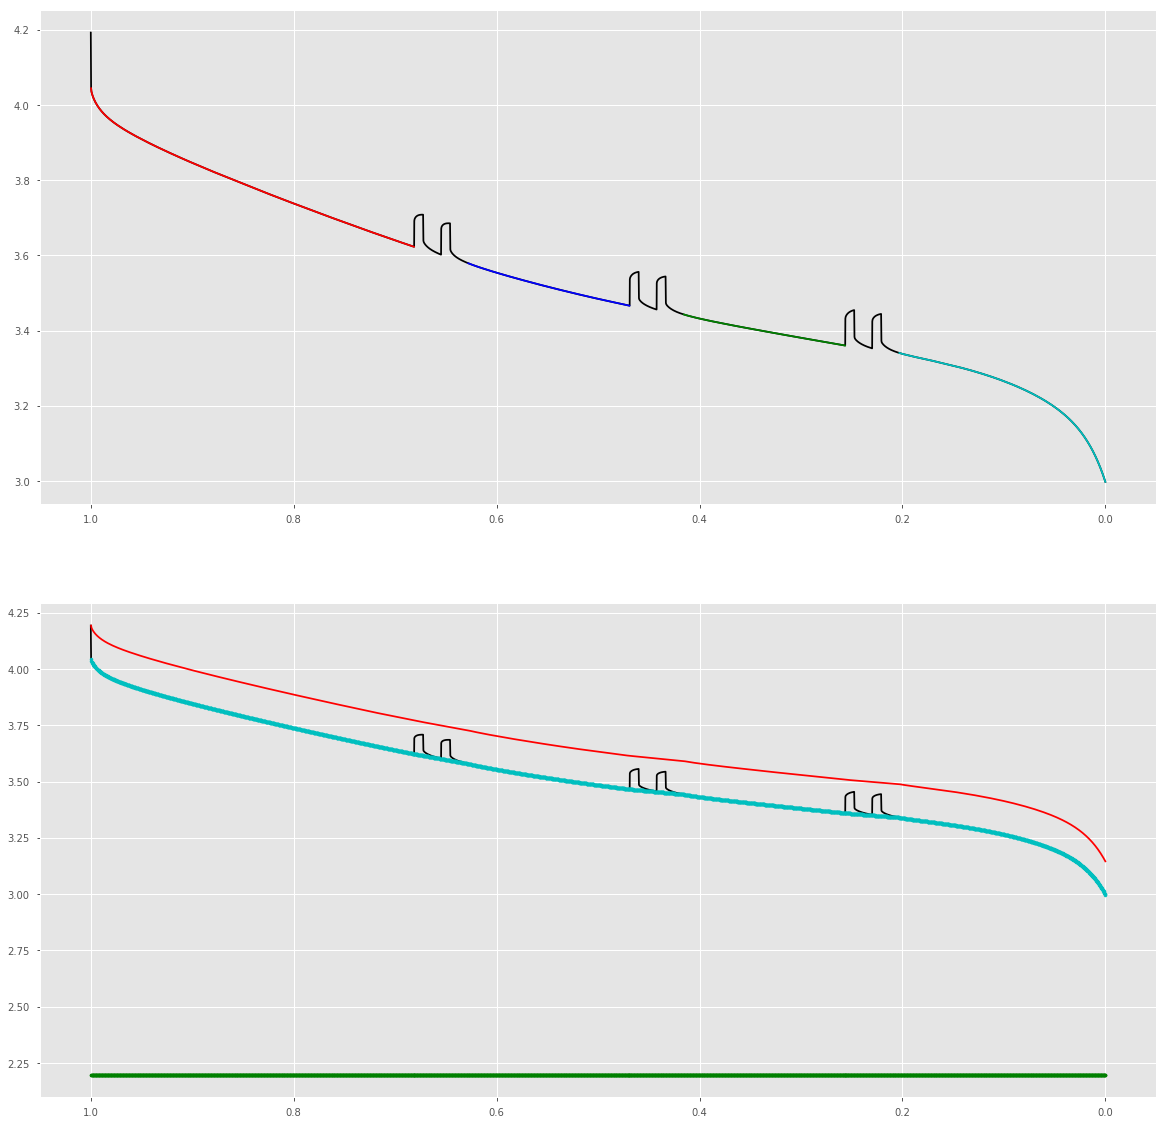

In [8]:
delta_t = low_high_index[0] + 1 - high_low_index[0]

delta_IR = voltage[0, 0] - voltage[0, 1]
print(delta_IR)

l1_soc = SoC[0, 1:high_low_index[0]]
l1_v = voltage[0, 1:high_low_index[0]]
l1_current = current[0, 1:high_low_index[0]]

soc_rate = l1_soc[-1] - l1_soc[-2]

l2_soc = SoC[0, low_high_index[1]+delta_t:high_low_index[2]]
l2_v = voltage[0, low_high_index[1]+delta_t:high_low_index[2]]
l2_current = current[0, low_high_index[1]+delta_t:high_low_index[2]]

m1_2 = (l2_v[0, 0] - l1_v[0, -1])/(l2_soc[0] - l1_soc[-1])
l1_l2_soc = np.arange(l1_soc[-1] - soc_rate, l2_soc[0], soc_rate)
l1_l2_v_interp = m1_2*(l1_l2_soc - l1_soc[-1]) + l1_v[0, -1] 
l1_l2_v_interp = np.array(l1_l2_v_interp, ndmin=2)
l1_l2_I = np.ones_like(l1_l2_soc)*l1_current[-1]

l3_soc = SoC[0, low_high_index[3]+delta_t:high_low_index[4]]
l3_v = voltage[0, low_high_index[3]+delta_t:high_low_index[4]]
l3_current = current[0, low_high_index[3]+delta_t:high_low_index[4]]

m2_3 = (l3_v[0, 0] - l2_v[0, -1])/(l3_soc[0] - l2_soc[-1])
l2_l3_soc = np.arange(l2_soc[-1] - soc_rate, l3_soc[0], soc_rate)
l2_l3_v_interp = m2_3*(l2_l3_soc - l2_soc[-1]) + l2_v[0, -1] 
l2_l3_v_interp = np.array(l2_l3_v_interp, ndmin=2)
l2_l3_I = np.ones_like(l2_l3_soc)*l2_current[-1]

l4_soc = SoC[0, low_high_index[5]+delta_t:]
l4_v = voltage[0, low_high_index[5]+delta_t:]
l4_current = current[0, low_high_index[5]+delta_t:]

m3_4 = (l4_v[0, 0] - l3_v[0, -1])/(l4_soc[0] - l3_soc[-1])
l3_l4_soc = np.arange(l3_soc[-1] - soc_rate, l4_soc[0], soc_rate)
l3_l4_v_interp = m3_4*(l3_l4_soc - l3_soc[-1]) + l3_v[0, -1] 
l3_l4_v_interp = np.array(l3_l4_v_interp, ndmin=2)
l3_l4_I = np.ones_like(l3_l4_soc)*l3_current[-1]


SoC_smoothed = np.array(np.concatenate((l1_soc, l1_l2_soc, l2_soc, l2_l3_soc, l3_soc, l3_l4_soc, l4_soc)), ndmin=2)
print(SoC_smoothed.shape, type(SoC_smoothed))
V_smoothed = np.array(np.concatenate((l1_v, l1_l2_v_interp, l2_v, l2_l3_v_interp, l3_v, l3_l4_v_interp, l4_v), axis=1), ndmin=2)
VoC_smoothed = V_smoothed + delta_IR
print(V_smoothed.shape, type(V_smoothed))
Current_smoothed = np.array(np.concatenate((l1_current, l1_l2_I, l2_current, l2_l3_I, l3_current, l3_l4_I, l4_current)), ndmin=2)
print(Current_smoothed.shape, type(Current_smoothed))

plt.subplot(211)
plt.plot(SoC.T, voltage.T, '-k')
plt.plot(l1_soc.T, l1_v.T, '-r')
plt.plot(l2_soc.T, l2_v.T, '-b')
plt.plot(l3_soc.T, l3_v.T, '-g')
plt.plot(l4_soc.T, l4_v.T, '-c')
plt.gca().invert_xaxis()
plt.subplot(212)
plt.plot(SoC.T, voltage.T, '-k')
plt.plot(SoC_smoothed.T, V_smoothed.T, '.c')
plt.plot(SoC_smoothed.T, VoC_smoothed.T, '-r')
plt.plot(SoC_smoothed.T, Current_smoothed.T, '.g')
plt.gca().invert_xaxis()


In [9]:
def apply_scale(X, X_min, X_max):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    return (X - X_min)/(X_max - X_min)

In [15]:
class VoCNetwork(nn.Module):
    def __init__(self):
        super(VoCNetwork, self).__init__()
        self.voc_hl1 = nn.Linear(1, 512)
        self.voc_hl2 = nn.Linear(512,256)
        self.voc_out = nn.Linear(256, 1)
    def forward(self, SoC):
        voc = torch.sigmoid(self.voc_hl1(SoC))
        voc = torch.sigmoid(self.voc_hl2(voc))
        voc = self.voc_out(voc)
        return voc

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
voc = VoCNetwork()
voc.to(device)
save_network = "./Trained_Models/VoC_network_small_v1.mdl"
retrain = True
if retrain:
    voc.load_state_dict(torch.load(save_network))
else:
    for W in voc.parameters():
        nn.init.normal_(W)
optimiser = optim.Adam(voc.parameters())

epoch 0, time since start: 0m 0s, estimated remaining time: 0h 31m 23s


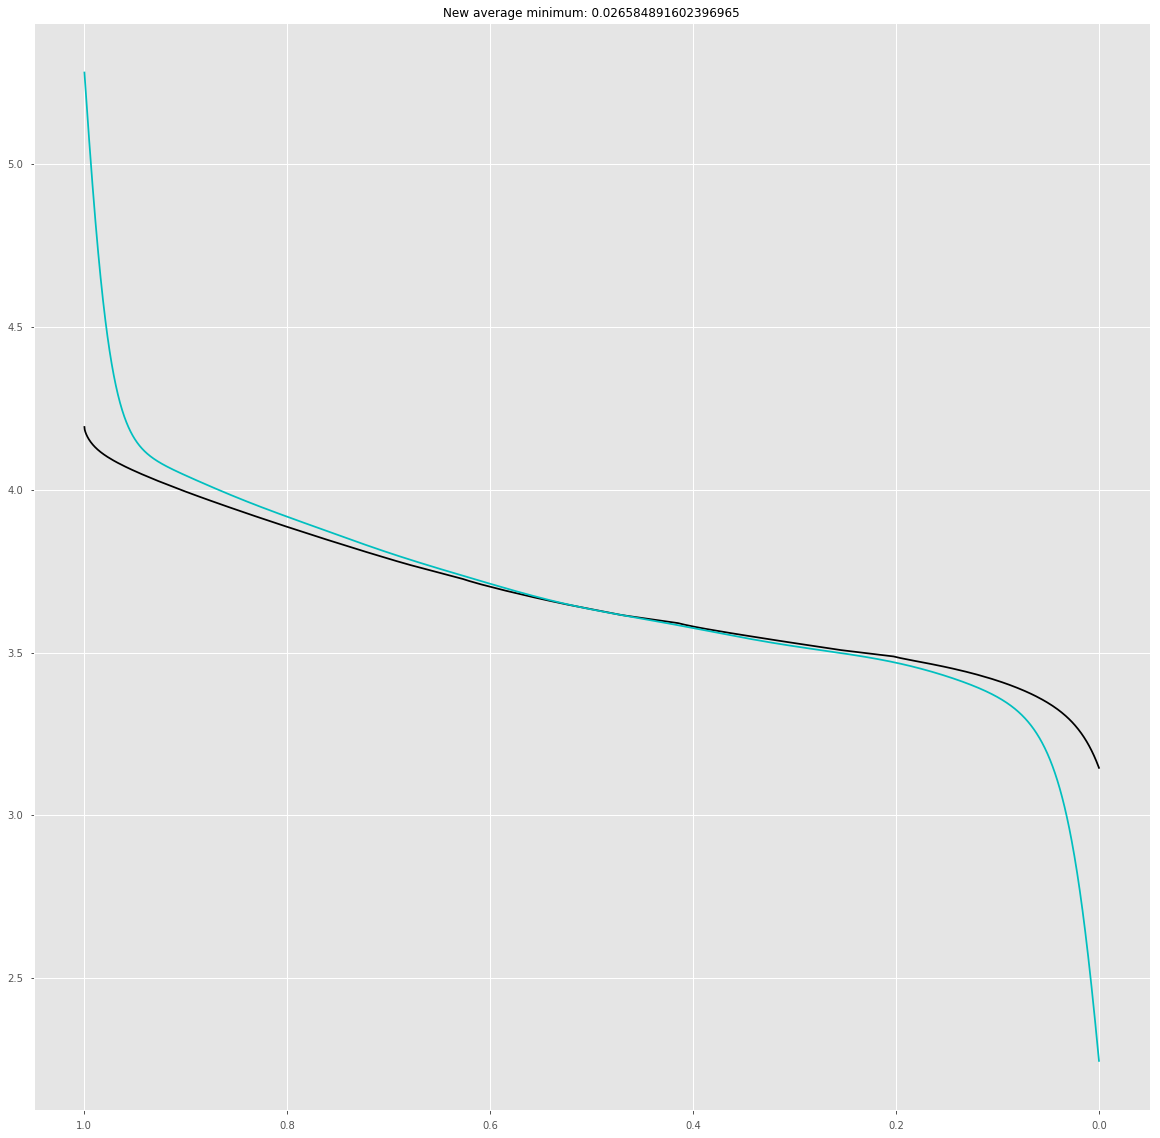

epoch 10000, time since start: 0m 20s, estimated remaining time: 0h 6m 33s


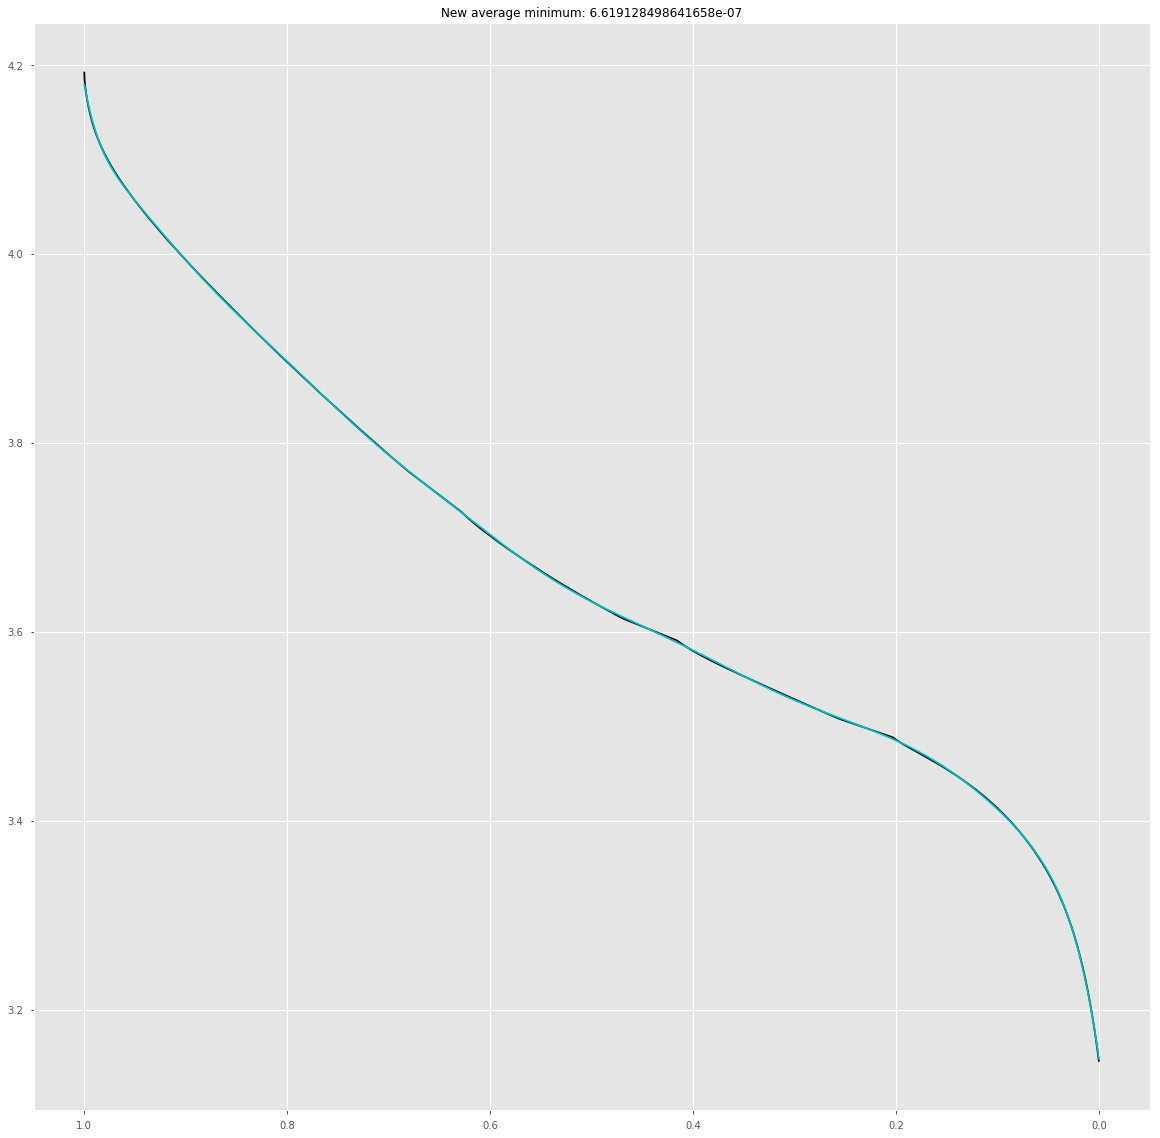

epoch 20000, time since start: 0m 39s, estimated remaining time: 0h 5m 55s


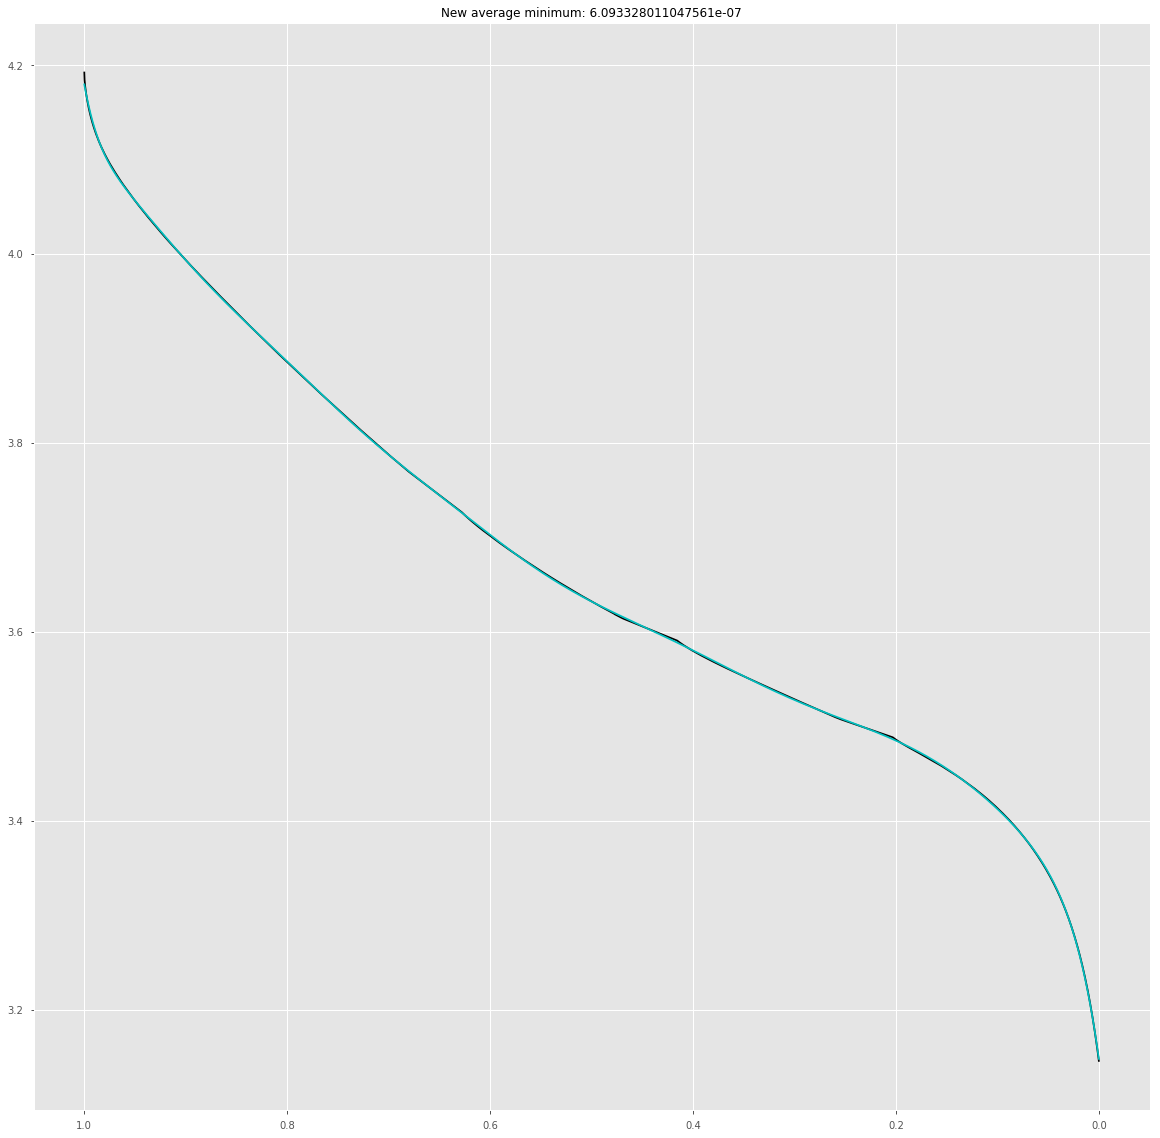

epoch 30000, time since start: 0m 57s, estimated remaining time: 0h 5m 27s


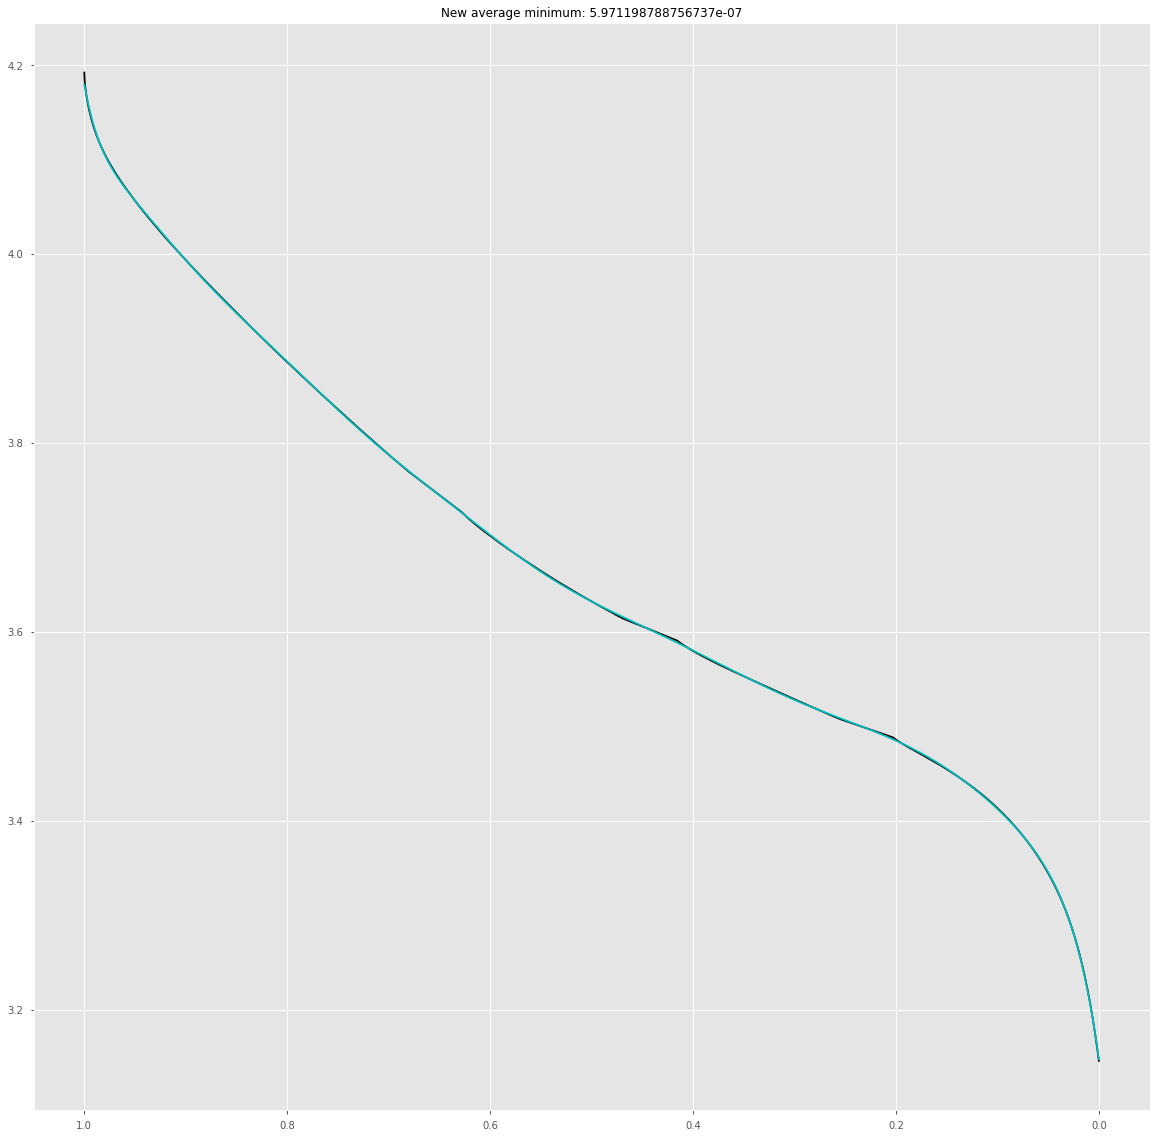

epoch 40000, time since start: 1m 15s, estimated remaining time: 0h 5m 2s


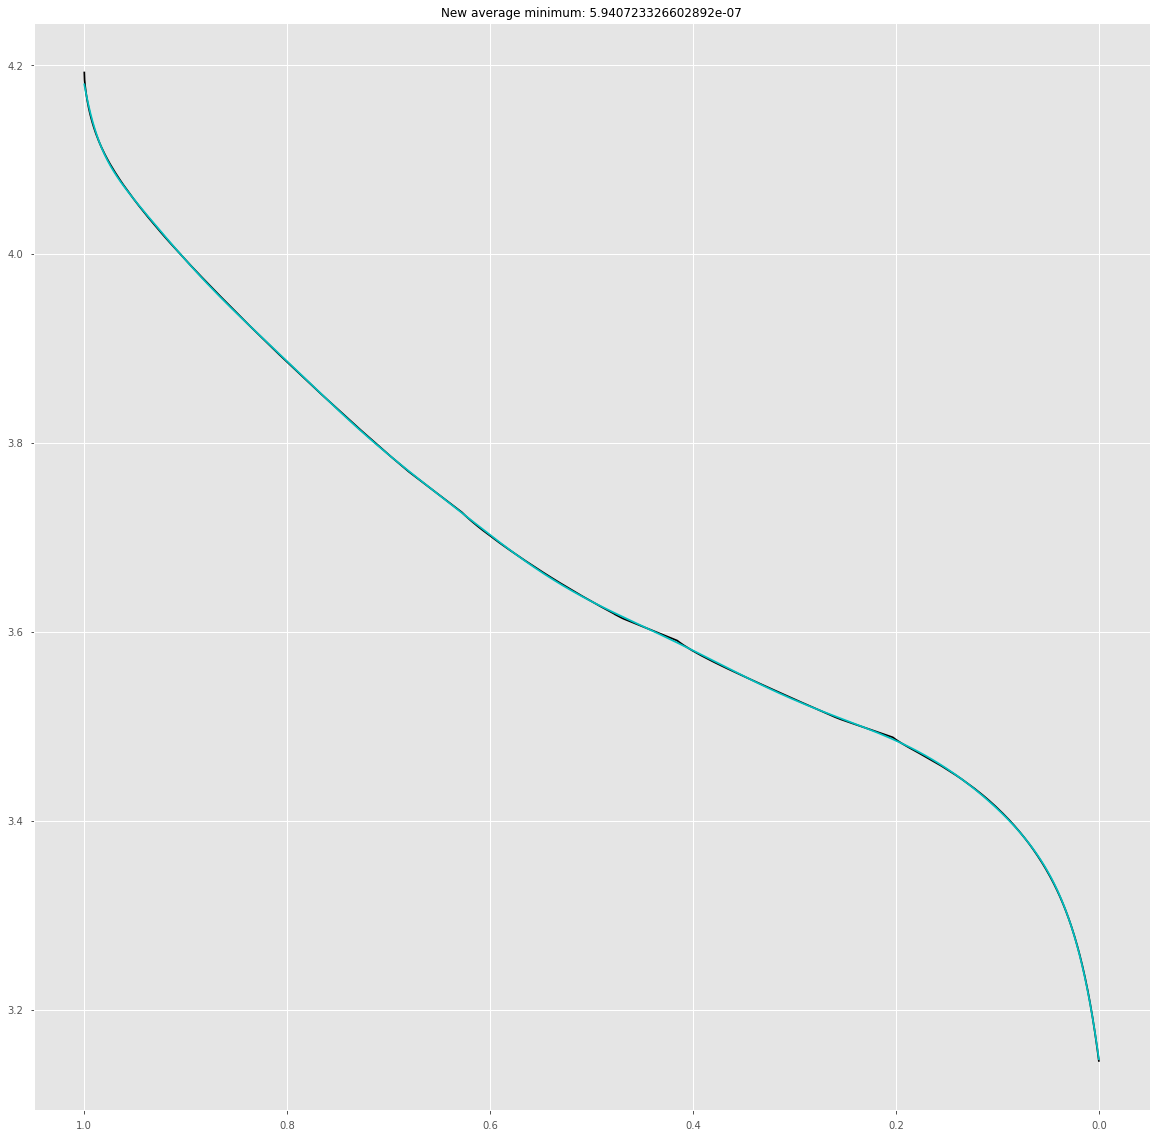

epoch 50000, time since start: 1m 33s, estimated remaining time: 0h 4m 39s


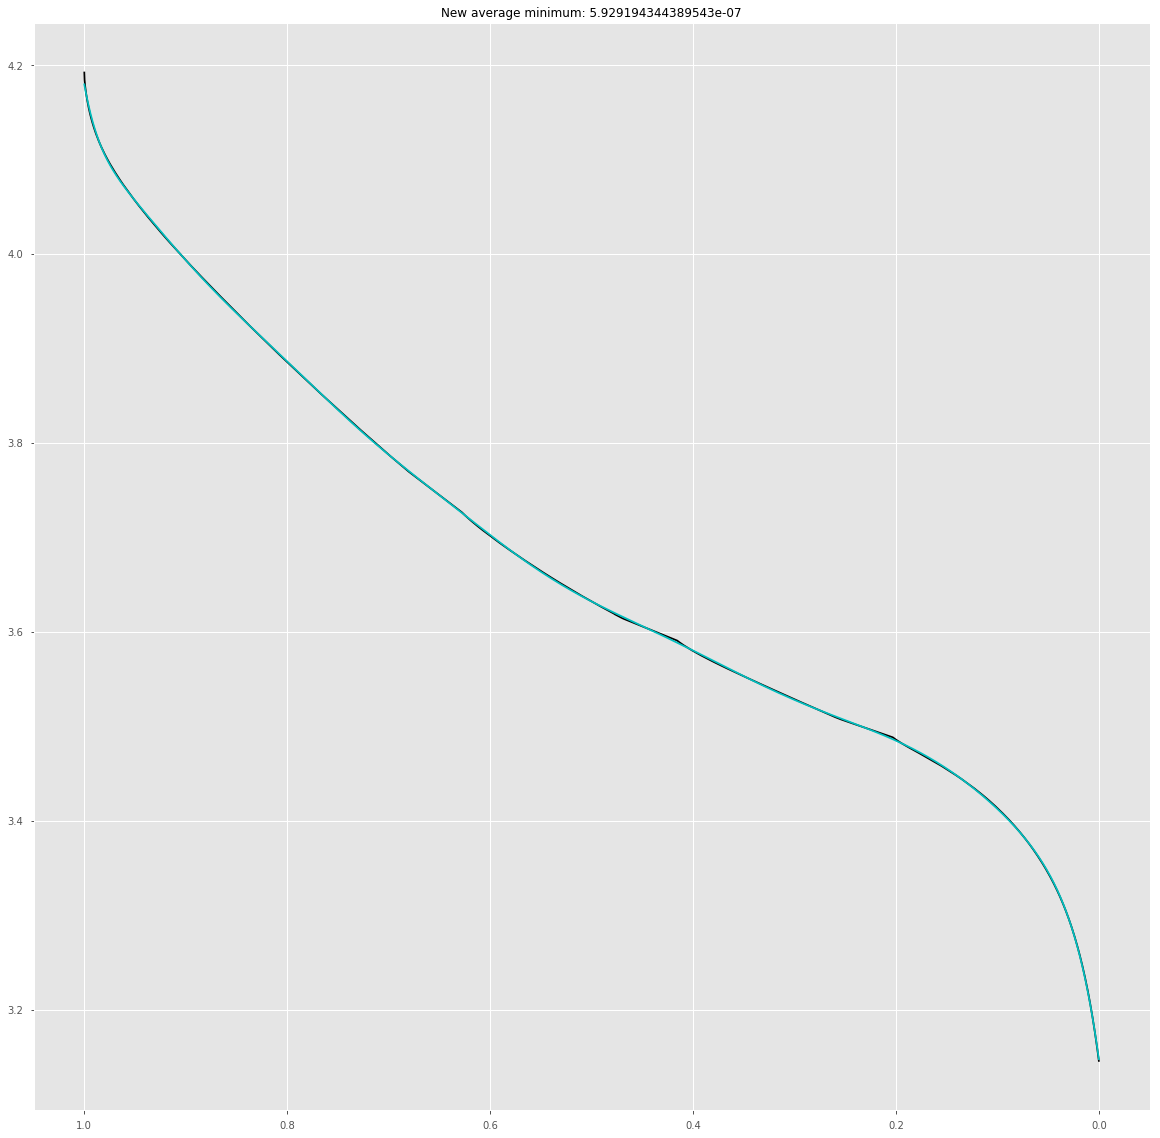

epoch 60000, time since start: 1m 51s, estimated remaining time: 0h 4m 19s


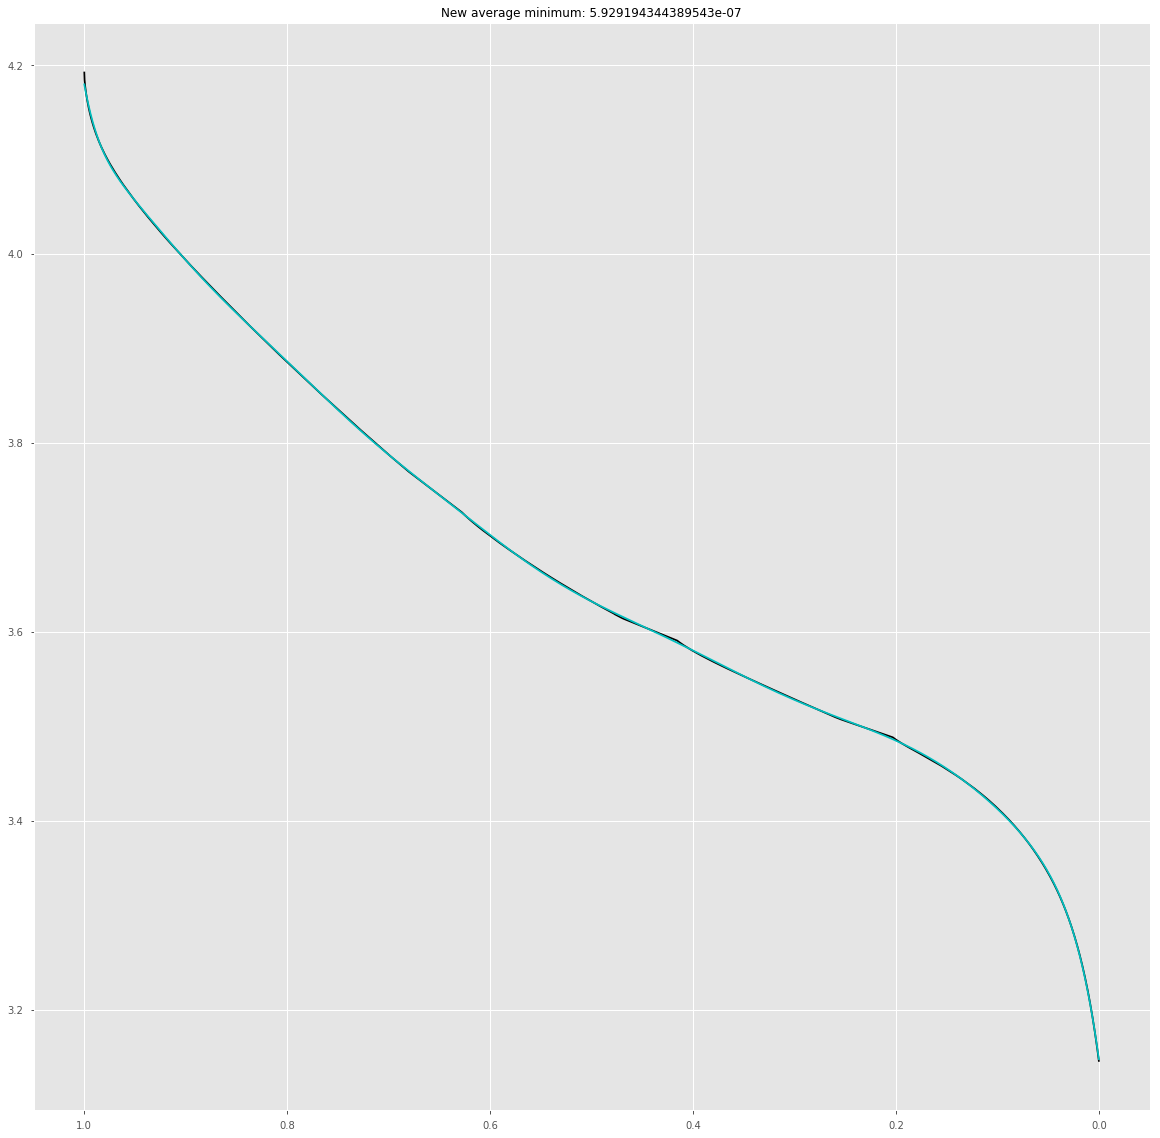

epoch 70000, time since start: 2m 10s, estimated remaining time: 0h 4m 2s


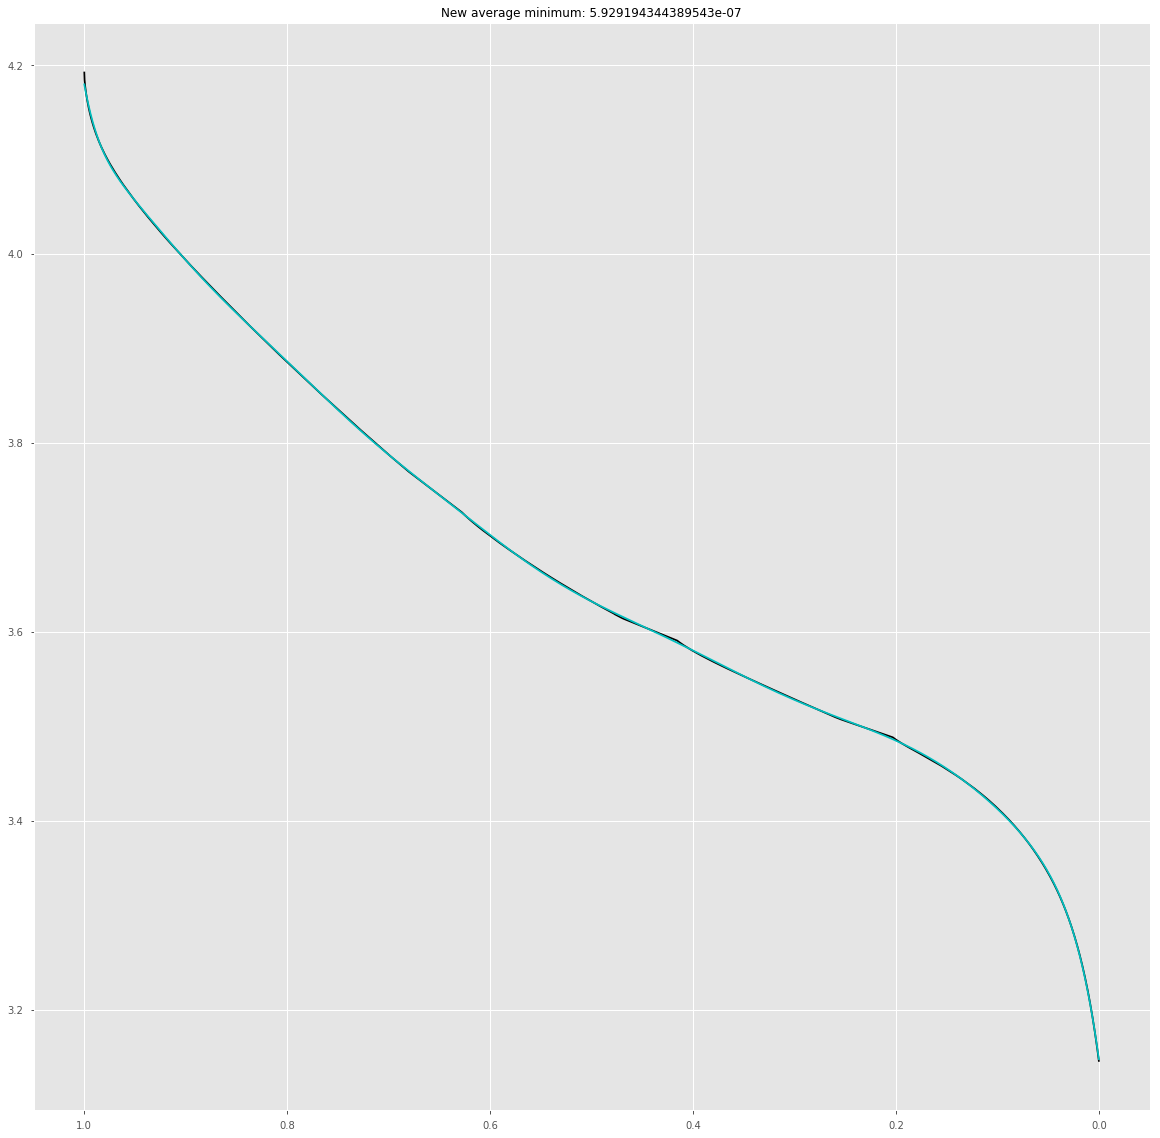

epoch 80000, time since start: 2m 29s, estimated remaining time: 0h 3m 43s


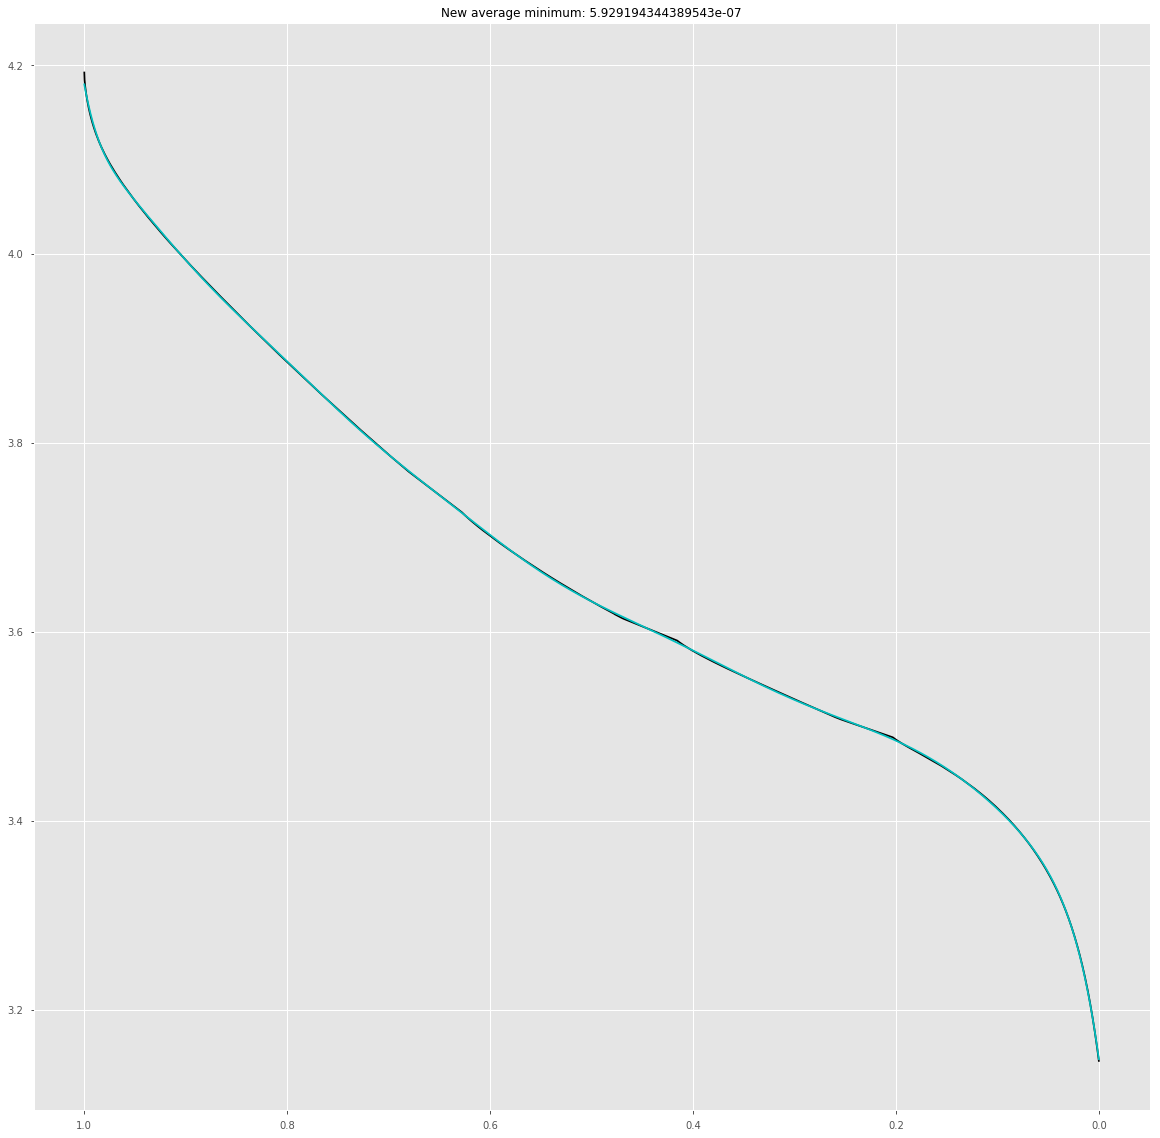

epoch 90000, time since start: 2m 47s, estimated remaining time: 0h 3m 25s


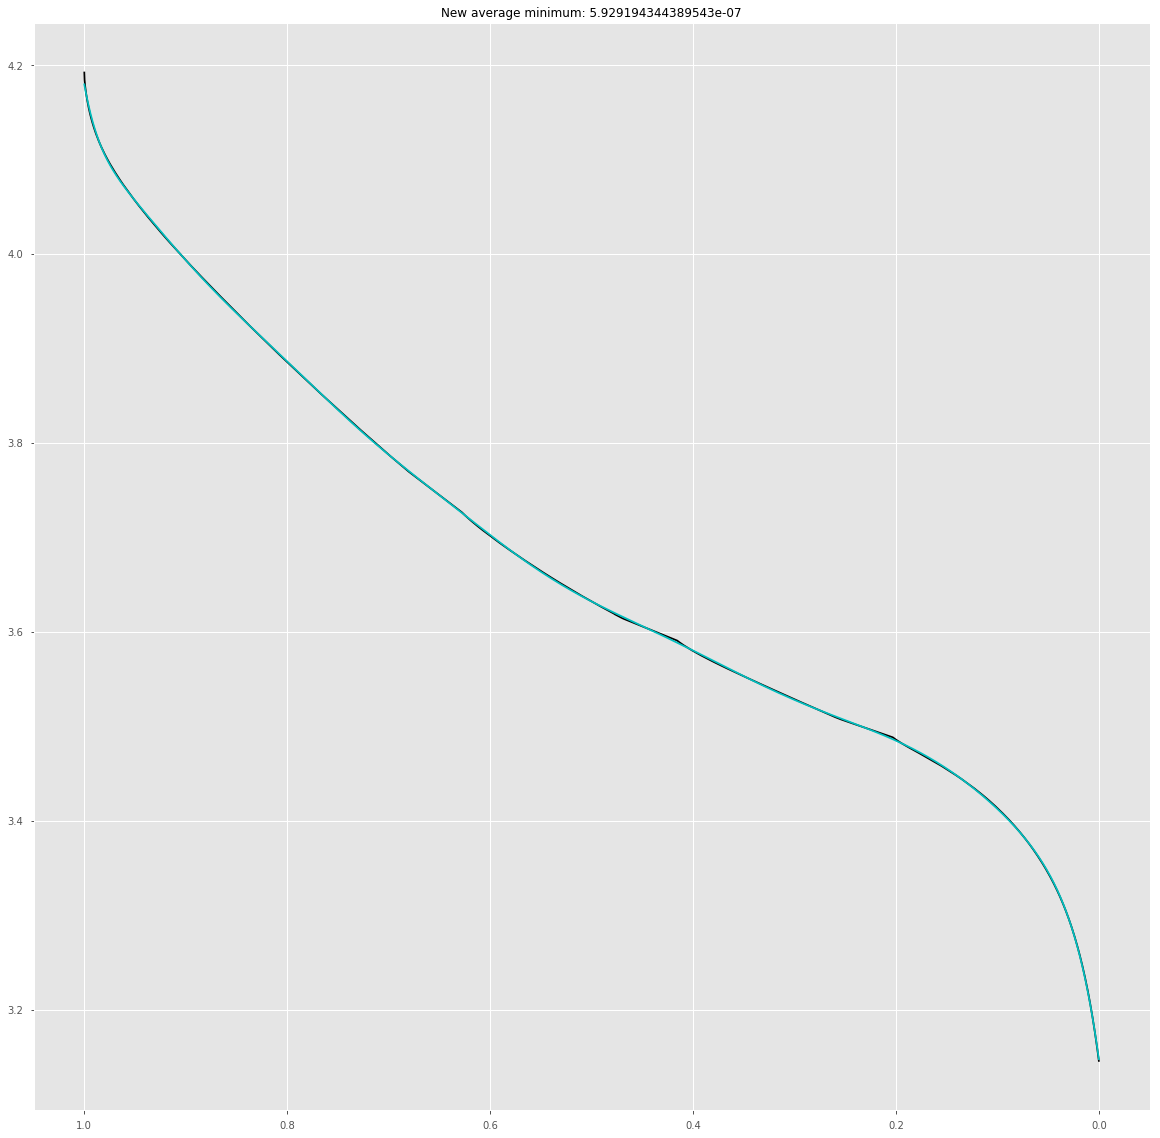

epoch 100000, time since start: 3m 6s, estimated remaining time: 0h 3m 6s


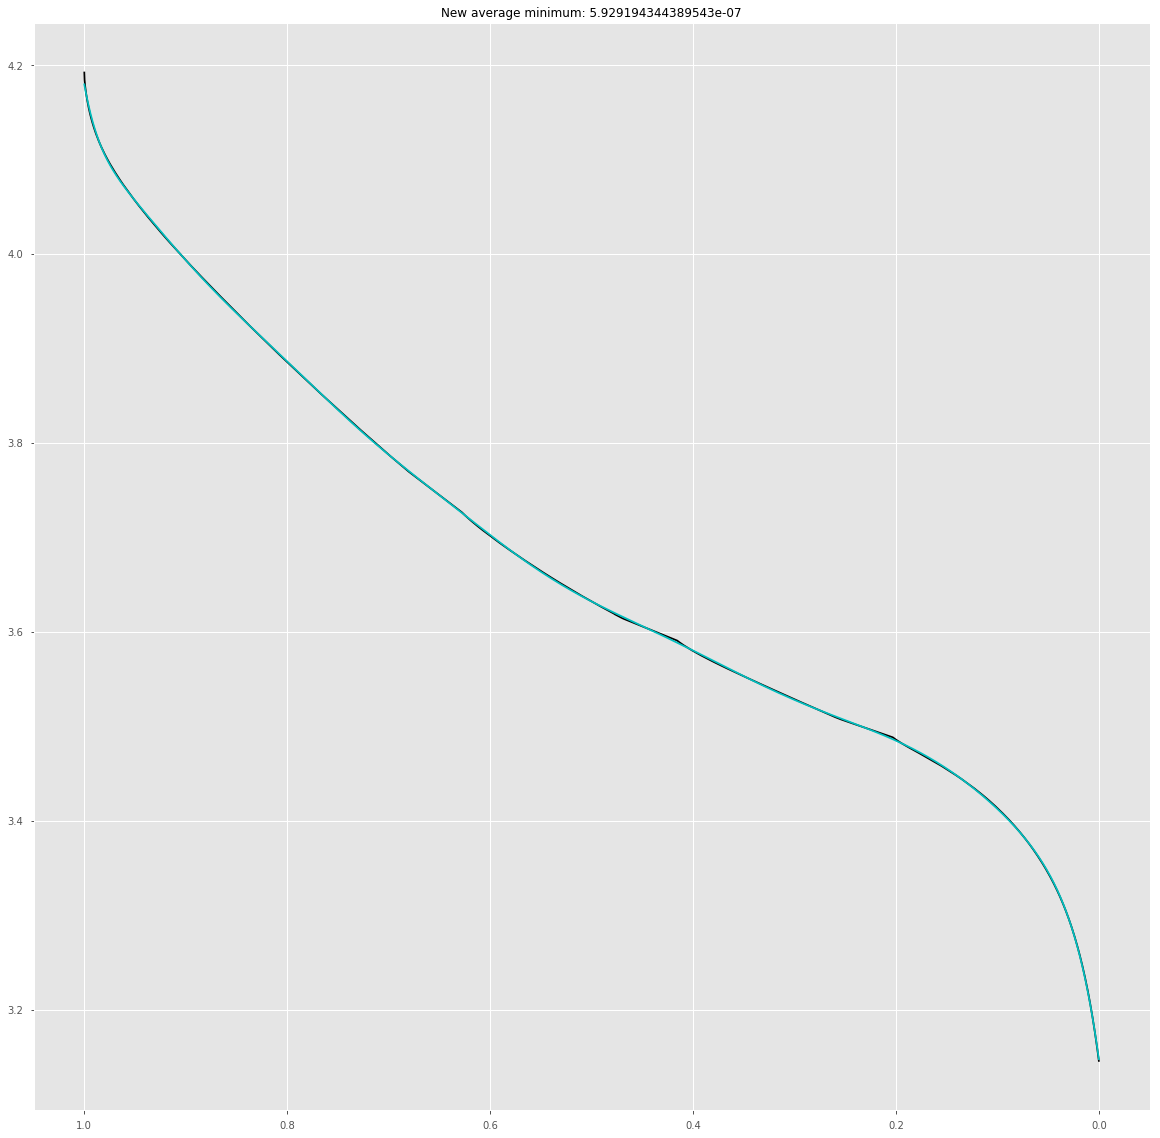

epoch 110000, time since start: 3m 25s, estimated remaining time: 0h 2m 47s


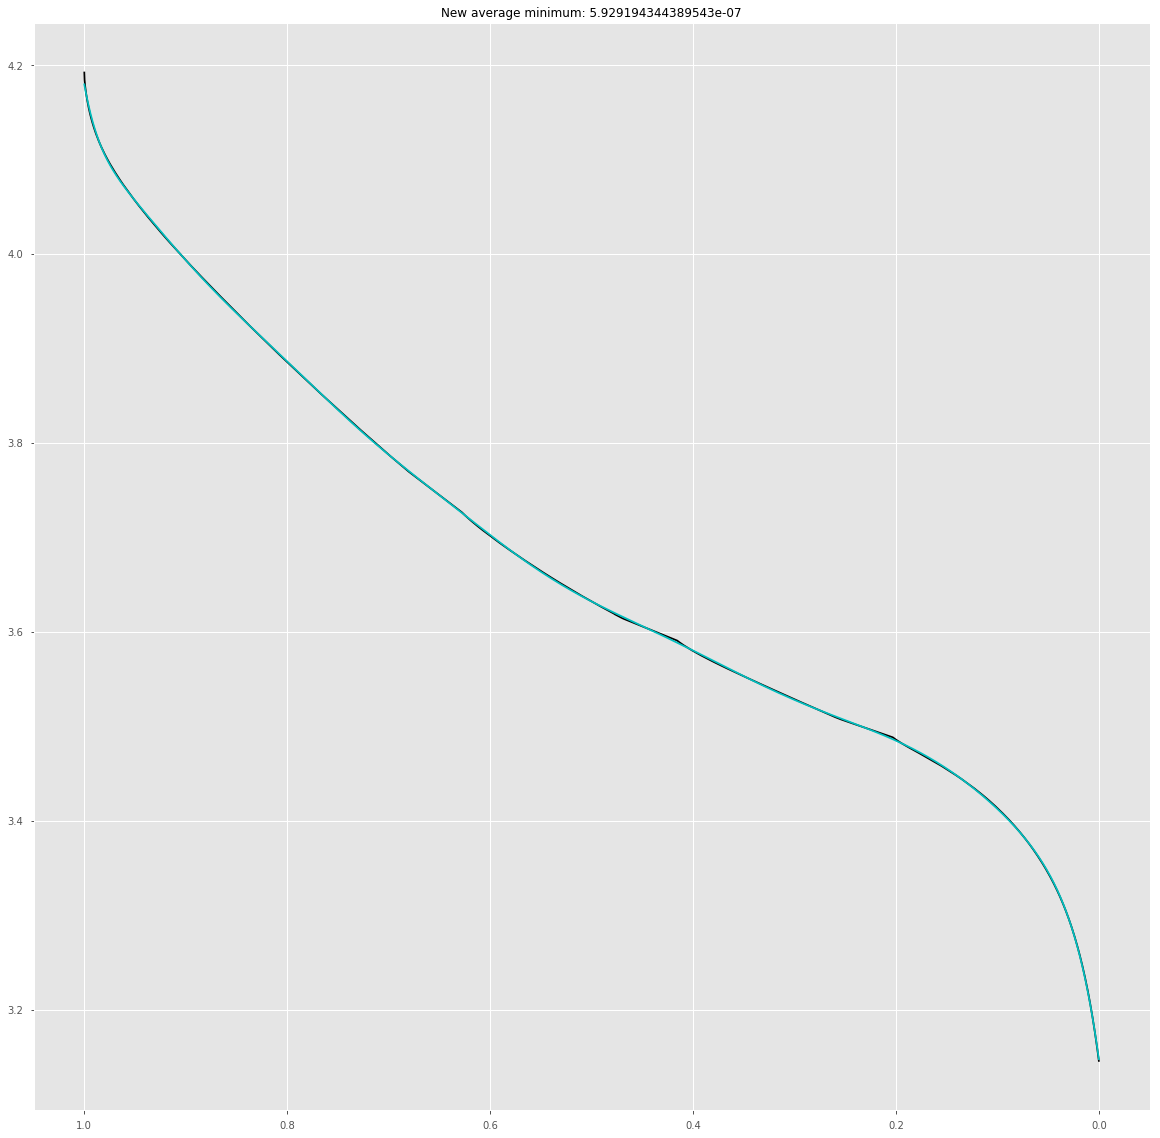

epoch 120000, time since start: 3m 43s, estimated remaining time: 0h 2m 29s


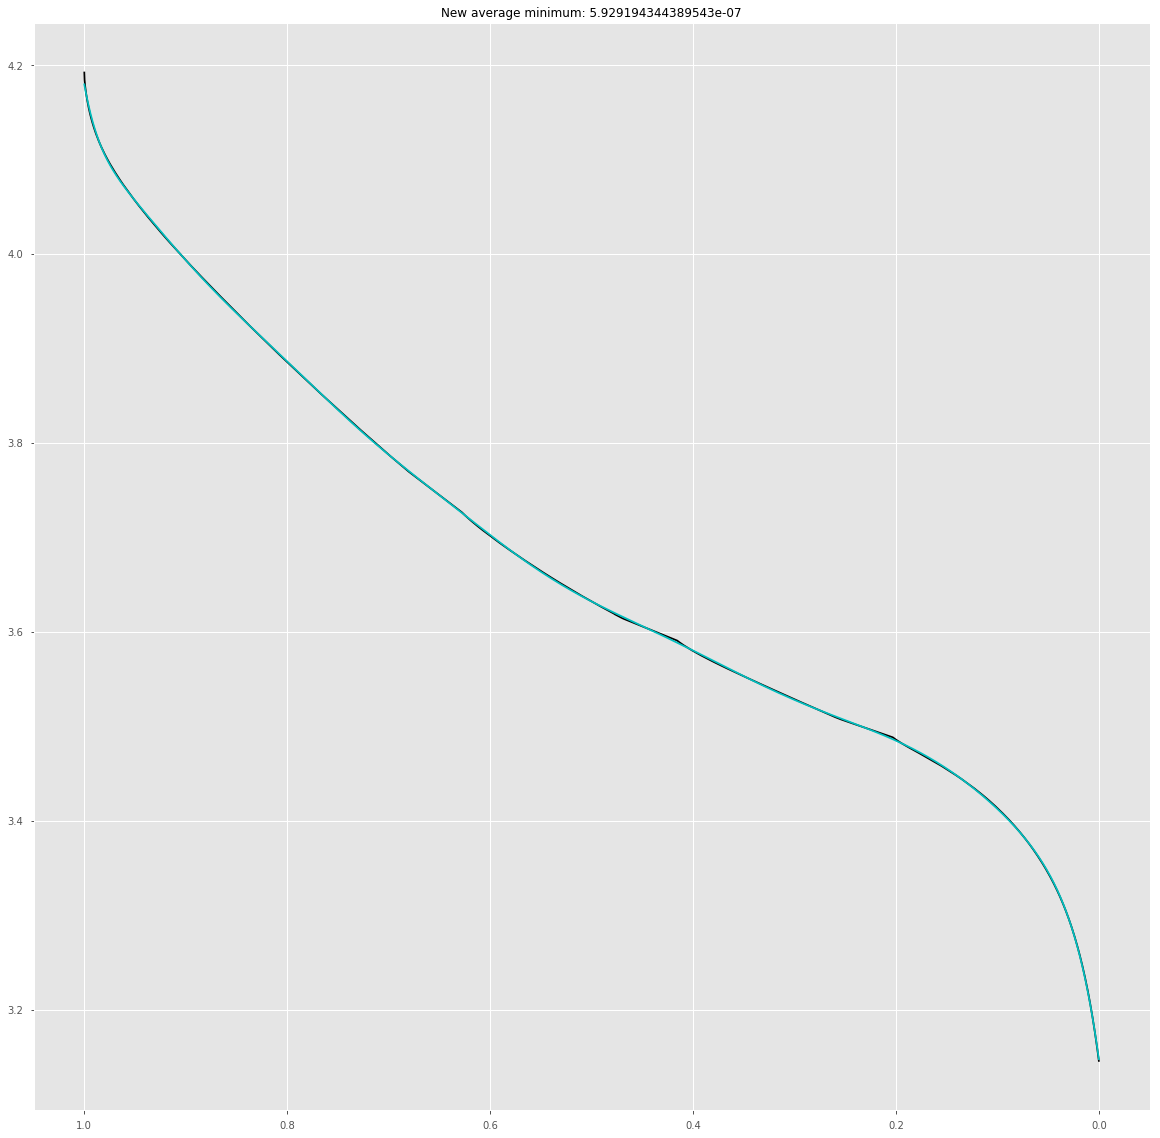

epoch 130000, time since start: 4m 3s, estimated remaining time: 0h 2m 11s


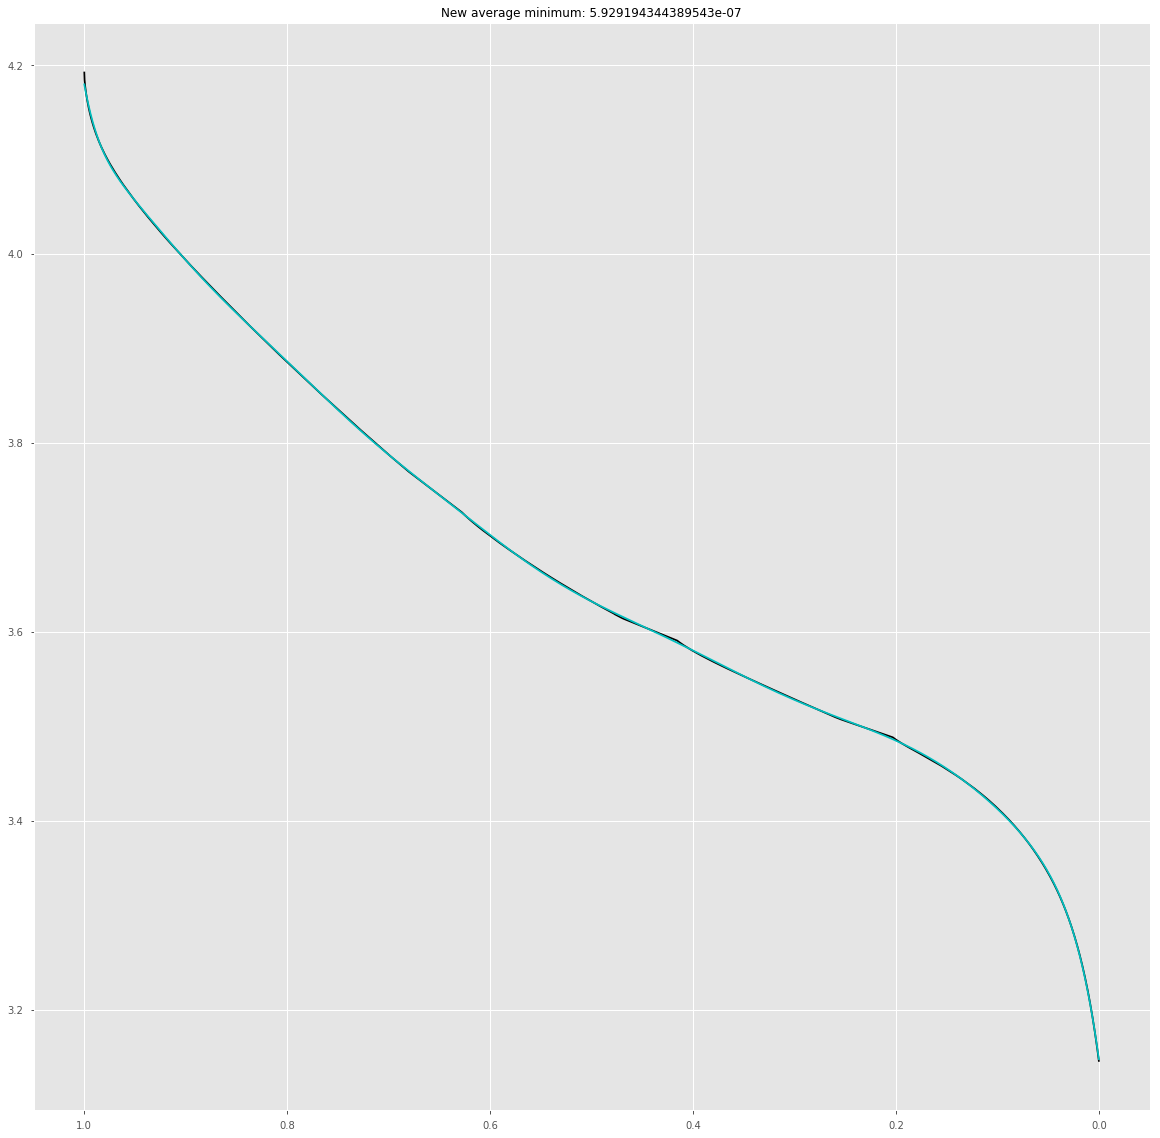

epoch 140000, time since start: 4m 21s, estimated remaining time: 0h 1m 51s


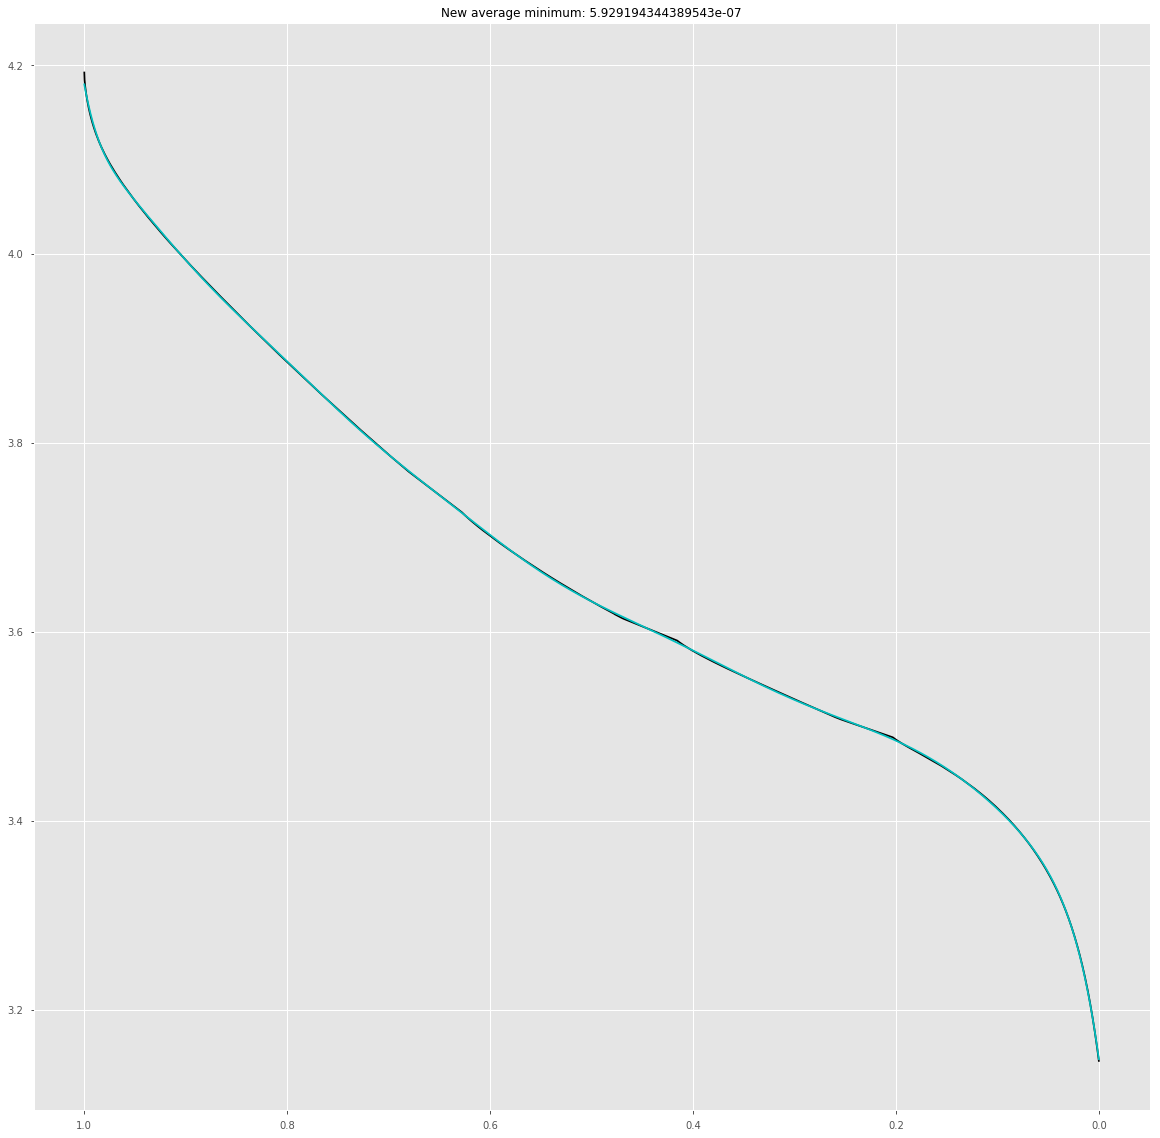

epoch 150000, time since start: 4m 39s, estimated remaining time: 0h 1m 33s


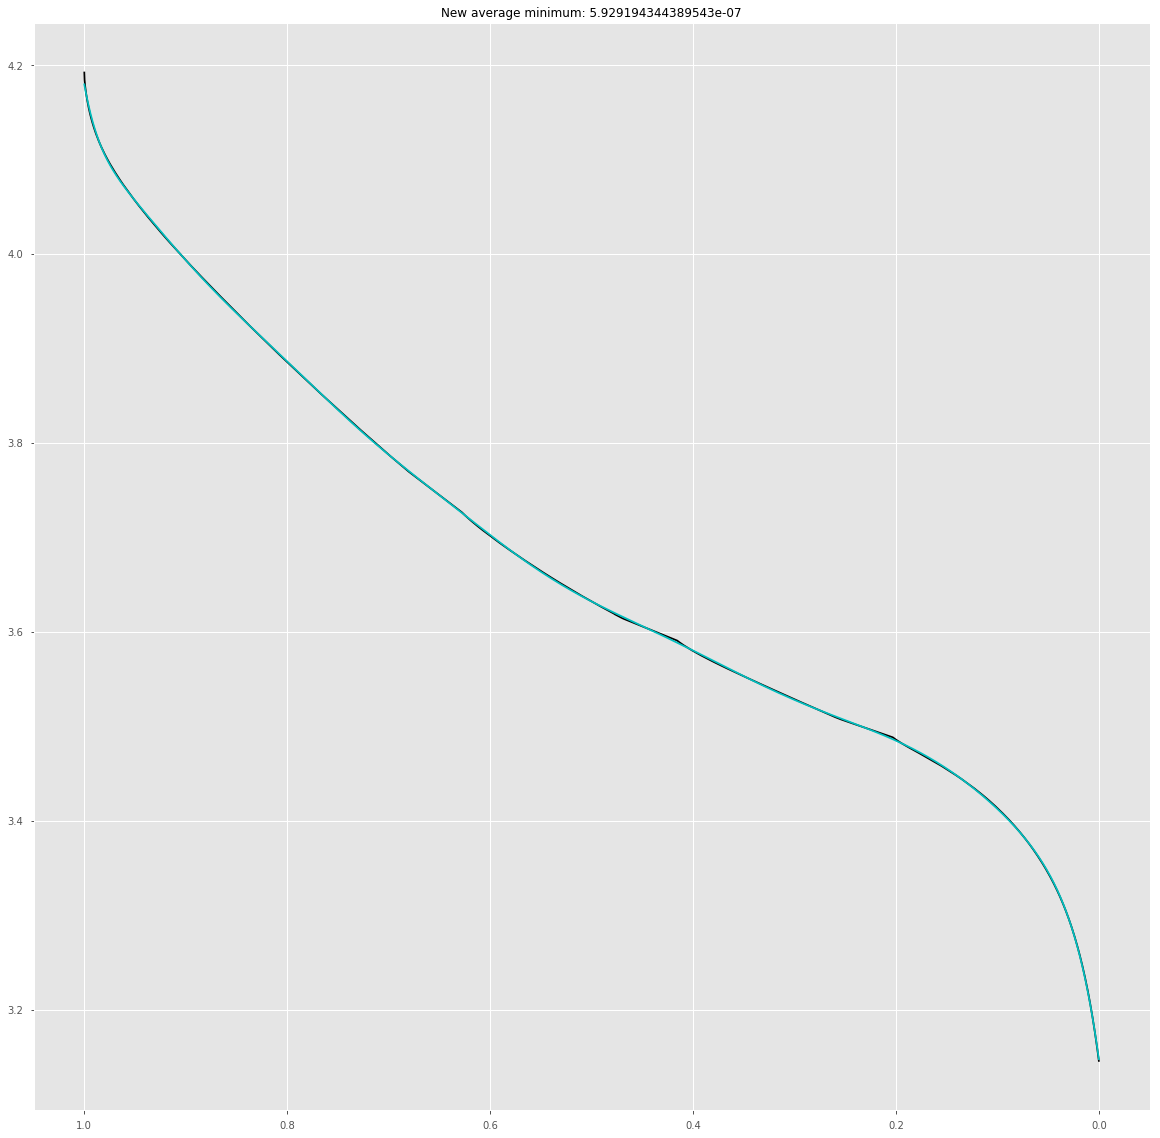

epoch 160000, time since start: 4m 58s, estimated remaining time: 0h 1m 14s


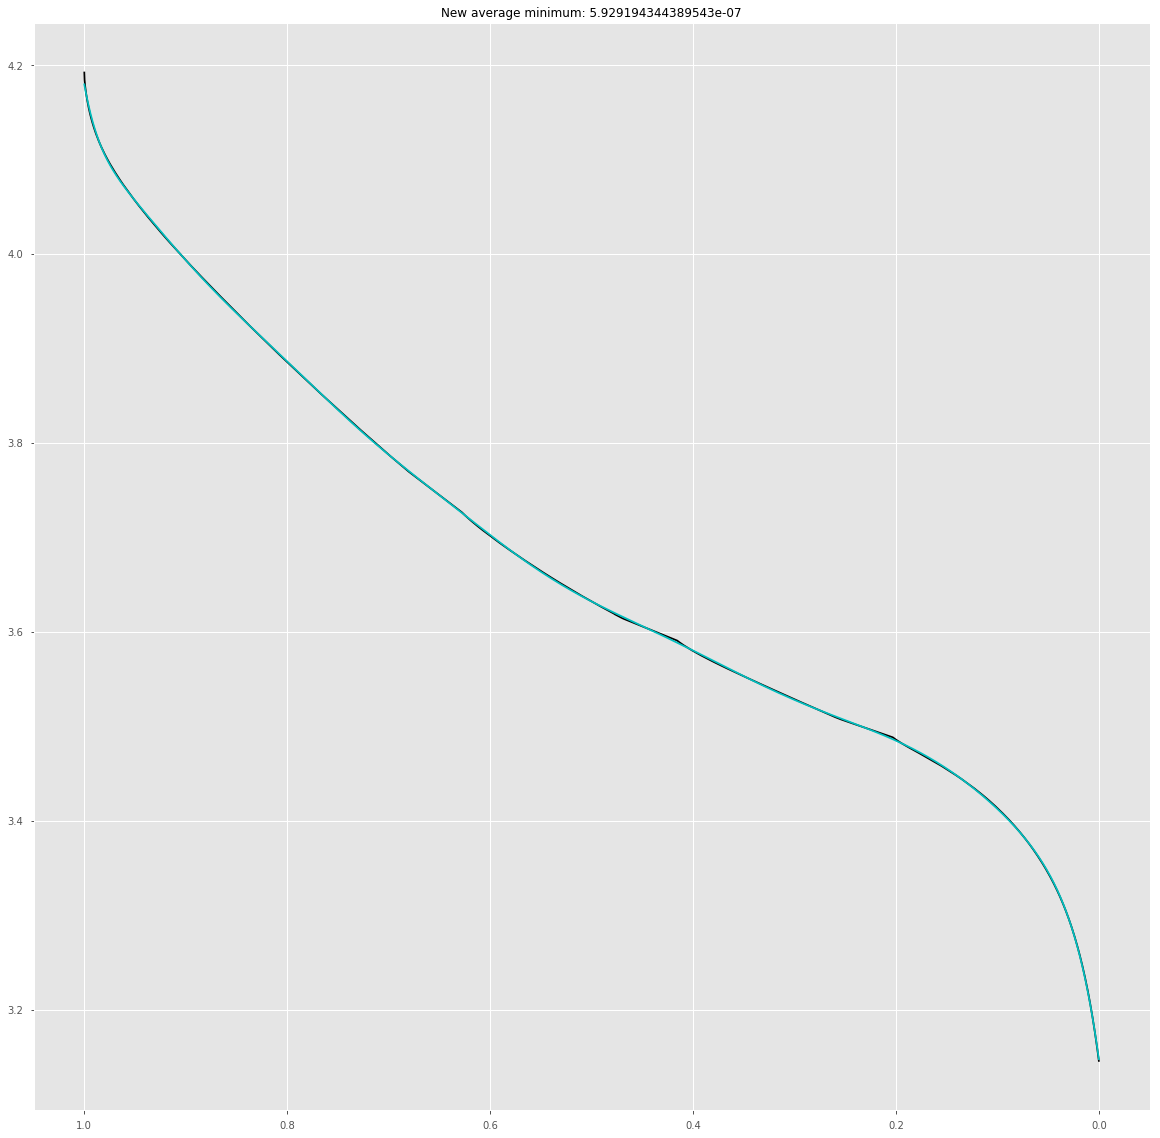

epoch 170000, time since start: 5m 17s, estimated remaining time: 0h 0m 56s


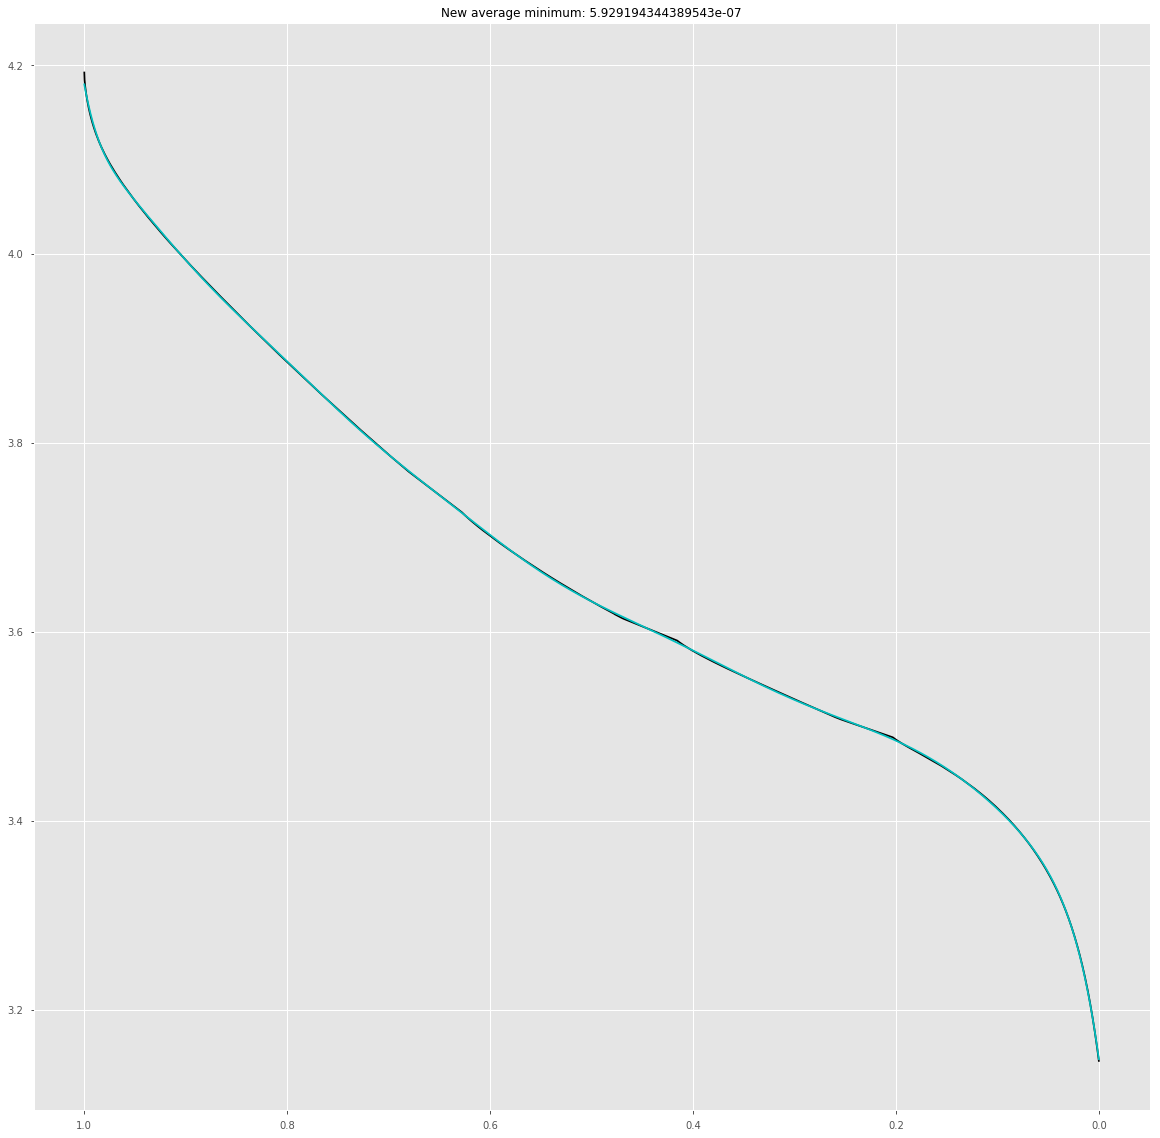

epoch 180000, time since start: 5m 36s, estimated remaining time: 0h 0m 37s


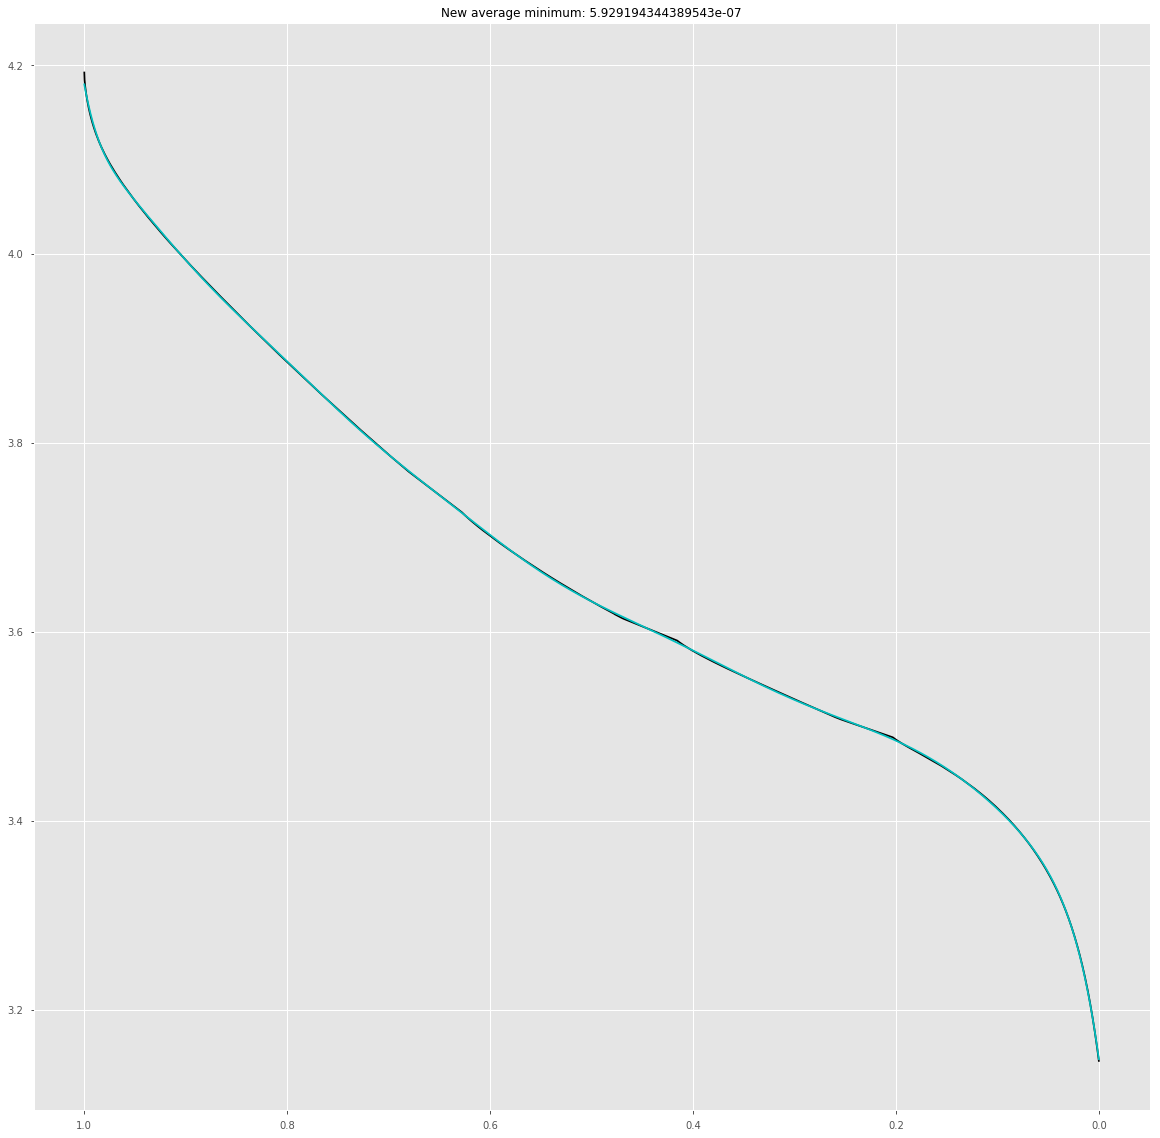

epoch 190000, time since start: 5m 54s, estimated remaining time: 0h 0m 18s


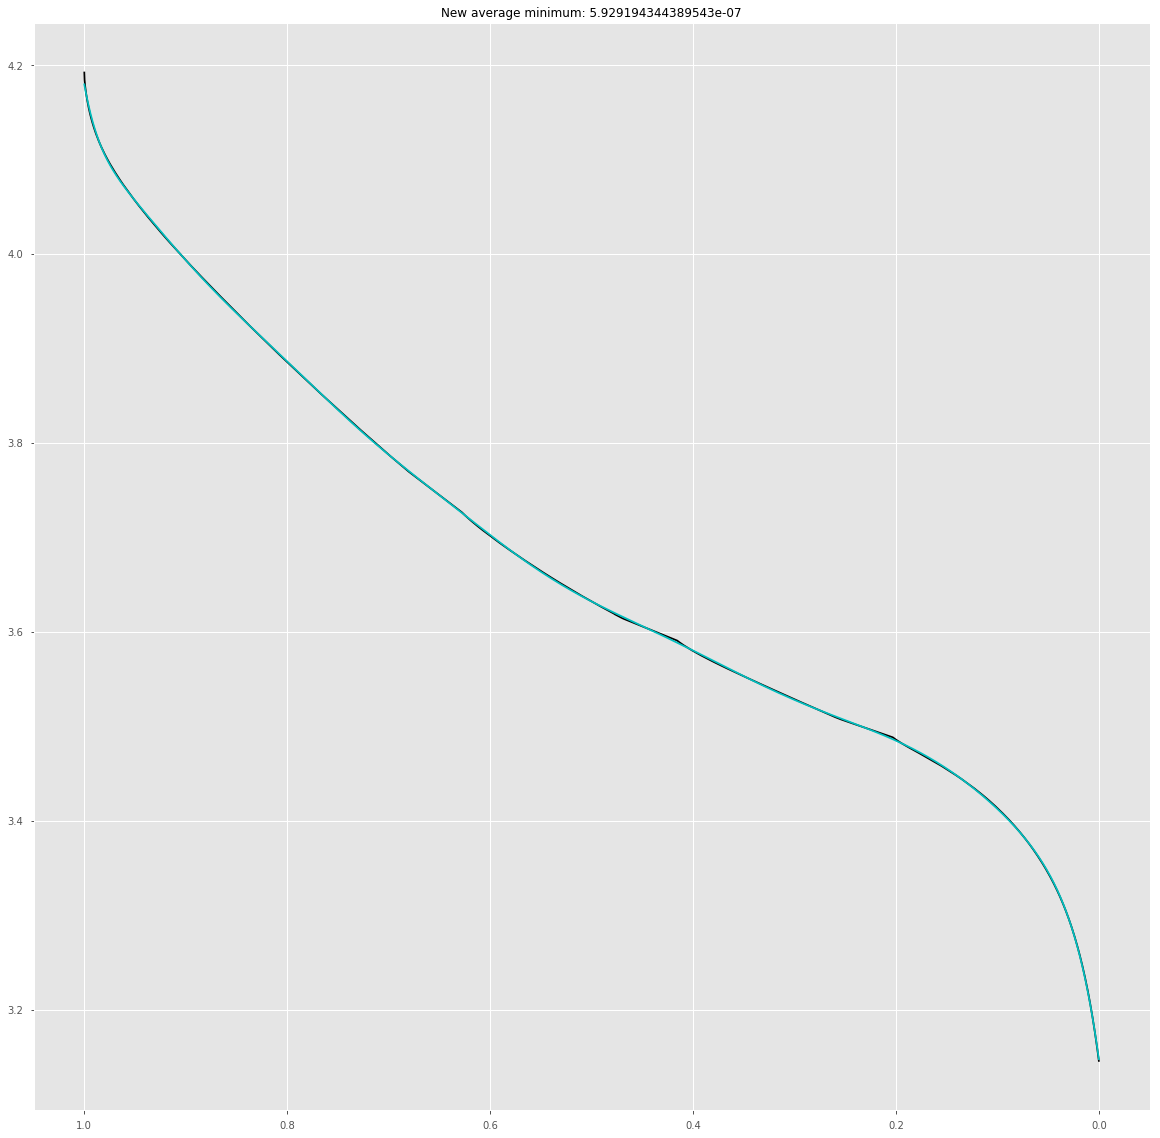

In [17]:
import time
import math

SoC_input = torch.from_numpy(SoC_smoothed.T).float().to(device)
VoC_target = torch.from_numpy(VoC_smoothed.T).float().to(device)
criterion = nn.MSELoss() # Mean Squared Loss

epochs = 200000
running_loss = 0.0
loss_min = 1e15
loss_hist = []

start = time.time()

def timeSince(since):
    now = time.time()
    interval = now - since
    m = math.floor(interval / 60)
    s = interval - m * 60
    return '%dm %ds' % (m, s), now, interval

for epoch in range(epochs):
    count = -1
    avg_loss = 0
    
    optimiser.zero_grad()
    voc_est = voc(SoC_input)
    loss = criterion(voc_est, VoC_target)
    loss.backward()
    optimiser.step()
    avg_loss += loss.item()
    loss_hist.append(loss.item())
    
    if avg_loss < loss_min:
        torch.save(voc.state_dict(), save_network)
        loss_min = avg_loss
        with torch.no_grad():
            voc_est_saved = voc_est.clone().to("cpu").numpy()
    
    if epoch % 10000 == 0:
        now_string, now, interval = timeSince(start)
        remaining_epochs = epochs-(epoch+1)
        remaining_time = interval*remaining_epochs/(epoch + 1)
        h_f = remaining_time / 60.0 / 60.0
        h = math.floor(h_f)
        m_f = (h_f - h)*60.0
        m = math.floor(m_f)
        s = (m_f - m)*60.0
        remaining_string = '%dh %dm %ds' % (h, m, s)
        time_string = "epoch {}, time since start: {}, estimated remaining time: {}".format(epoch, now_string, remaining_string)
        print(time_string)
        loss_string = "New average minimum: {}".format(loss_min)
#         print(loss_string)
        plt.figure()
        plt.title(loss_string)
        plt.plot(SoC_smoothed.T, VoC_smoothed.T, '-k')
        plt.plot(SoC_smoothed.T, voc_est_saved, '-c')
        plt.gca().invert_xaxis()
        plt.show()

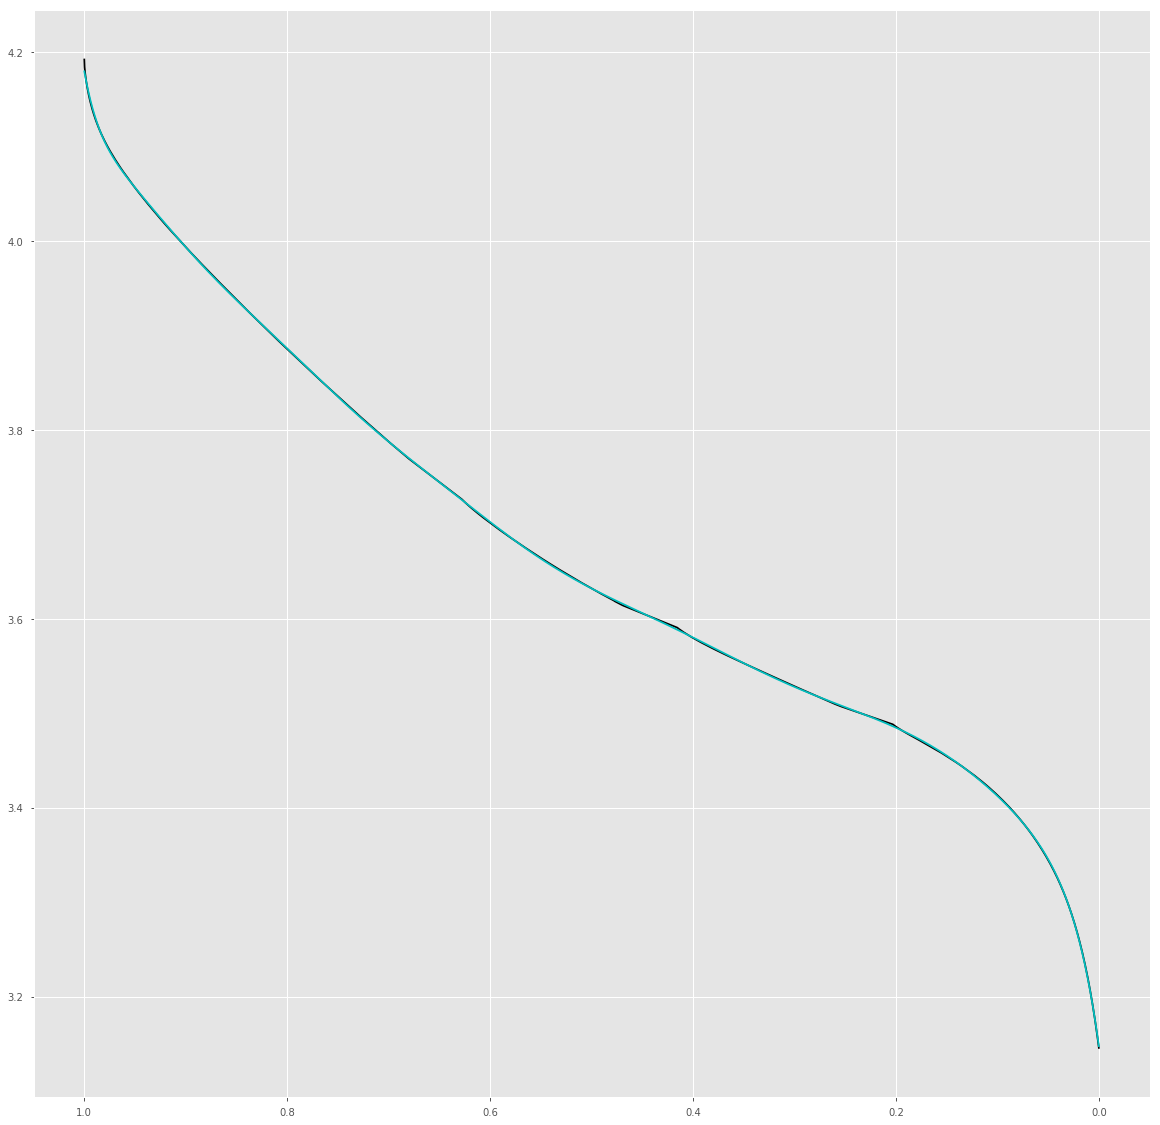

In [18]:
with torch.no_grad():
    voc.load_state_dict(torch.load(save_network))
    voc_est = voc(SoC_input)
    voc_est = voc_est.to("cpu").numpy()
plt.figure()
plt.plot(SoC_smoothed.T, VoC_smoothed.T, '-k')
plt.plot(SoC_smoothed.T, voc_est, '-c')
plt.gca().invert_xaxis()
plt.show()